In [1]:
def compute_scib_metrics(adata_post, emb_key, label_key, batch_key, model_name):
    """
    Run neighbors first, this program takes a long time

    :param adata_post:
    :param emb_key:
    :param label_key:
    :param batch_key:
    :param model_name:
    :return:
    """

    print('-' * 10 + 'start to compute scib metrics' + '-' * 10)

    from scib.metrics.lisi import lisi_graph
    from scib.metrics.silhouette import silhouette, silhouette_batch
    from scib.metrics.isolated_labels import isolated_labels
    from scib.metrics.kbet import kBET
    import timeit
    import numpy as np
    import pandas as pd

    start = timeit.default_timer()

    order = ['clisi', 'sil_labels', 'isolated_labels', 'ilisi', 'sil_batch', 'kBET']
    df = pd.DataFrame(index=[model_name], columns=order)
    df["ilisi"], df["clisi"] = lisi_graph(adata_post, batch_key=batch_key, label_key=label_key)
    df["sil_labels"] = silhouette(adata_post, group_key=label_key, embed=emb_key)
    # if "dpt_pseudotime" in adata_pre.obs.columns:
    #     df["trajectory_conservation"] = trajectory_conservation(adata_pre, adata_post, label_key=label_key)
    # else:
    #     df["trajectory_conservation"] = 'None'
    df["isolated_labels"] = isolated_labels(adata_post, label_key=label_key, batch_key=batch_key, embed=emb_key)
    df["sil_batch"] = silhouette_batch(adata_post, batch_key=batch_key, group_key=label_key, embed=emb_key)
    df['kBET'] = kBET(adata_post, batch_key=batch_key, label_key=label_key, embed=emb_key)

    l_bio = df.iloc[0].values[:3]
    l_batch = df.iloc[0].values[3:]
    overall_score = 0.6 * (np.mean(l_bio)) + 0.4 * (np.mean(l_batch))
    df['overall_score'] = overall_score

    end = timeit.default_timer()
    print(str(end - start) + ' sec')

    return df


In [1]:
import scanpy as sc
from scib.metrics import ilisi_graph

# 读取各方法的 h5ad 文件
paths = {
    "Harmony": "/root/Desktop/my_pan/workspace/Data/h5ad_output/harmony_corrected_bonemarrow_with_celltype.h5ad",
    "scVI": "/root/Desktop/my_pan/workspace/Data/h5ad_output/bonemarrow_merged_scvi_with_celltype_and_leiden.h5ad",
    "scAtlasVAE": "/root/Desktop/my_pan/workspace/Data/h5ad_output/new_merged_bonemarrow_batches_scatlasvae_with_celltype.h5ad"
}

reps = {
    "Harmony": "X_pca",
    "scVI": "X_scVI",
    "scAtlasVAE": "X_scatlasvae"
}

# 执行 iLISI
for method, path in paths.items():
    adata = sc.read_h5ad(path)
    if "batch" not in adata.obs:
        print(f"⚠️ {method} 中缺少 batch 列")
        continue
    score = ilisi_graph(
        adata,
        batch_key="batch",
        type_="embed",
        embed=adata.obsm[reps[method]],
        scale=True  # 可选
    )
    print(f"✅ {method} iLISI:", score)

TypeError: ilisi_graph() got an unexpected keyword argument 'embed'

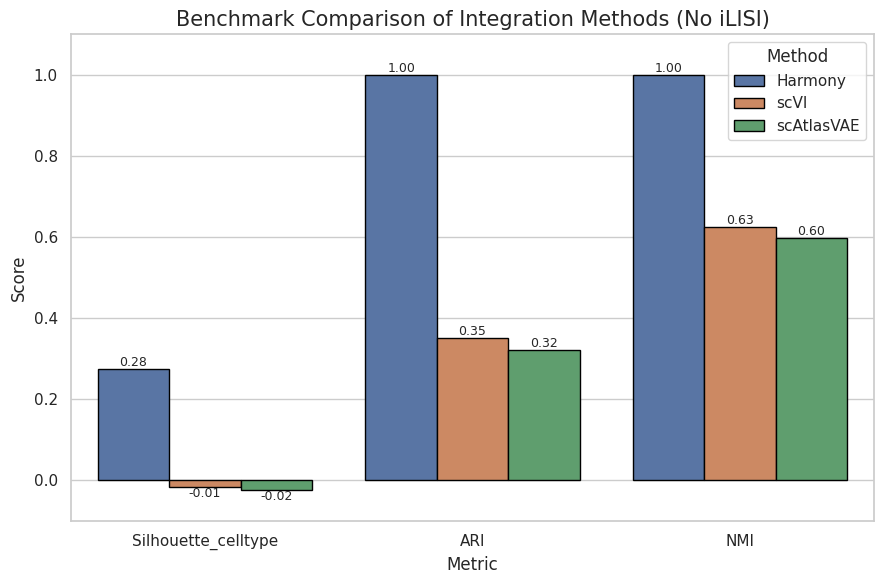

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置样式
sns.set(style="whitegrid")

# 构造数据
data = {
    "Method": ["Harmony", "scVI", "scAtlasVAE"],
    "Silhouette_celltype": [0.2753, -0.0149, -0.0233],
    "ARI": [1.0, 0.3522, 0.3206],
    "NMI": [1.0, 0.6260, 0.5975],
}

df = pd.DataFrame(data)

# 转换为长格式
df_melted = df.melt(id_vars="Method", var_name="Metric", value_name="Score")

# 设置画布大小
plt.figure(figsize=(9, 6))

# 绘制条形图
ax = sns.barplot(data=df_melted, x="Metric", y="Score", hue="Method", edgecolor="black")

# 添加数值标签
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=9)

# 设置图形参数
plt.title("Benchmark Comparison of Integration Methods (No iLISI)", fontsize=15)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metric", fontsize=12)
plt.ylim(-0.1, 1.1)
plt.legend(title="Method", loc="upper right")
plt.tight_layout()
plt.show()


In [4]:
def compute_scib_metrics(adata_post, emb_key, label_key, batch_key, model_name):
    """
    Compute key scIB benchmark metrics using Python-only LISI.
    Suitable when R lisi package is unavailable.
    """

    print('-' * 10 + f' Computing scIB metrics for: {model_name} ' + '-' * 10)

    import timeit
    import numpy as np
    import pandas as pd
    from scib.metrics.lisi import ilisi_graph, clisi_graph
    from scib.metrics.silhouette import silhouette, silhouette_batch
    from scib.metrics.isolated_labels import isolated_labels
    from scib.metrics.kbet import kBET

    start = timeit.default_timer()

    metric_names = ['clisi', 'sil_labels', 'isolated_labels', 'ilisi', 'sil_batch', 'kBET']
    df = pd.DataFrame(index=[model_name], columns=metric_names)

    # LISI scores (Python-only)
    print("🔹 Calculating iLISI and cLISI (Python-only approximation)...")
    df["ilisi"] = ilisi_graph(adata_post, batch_key=batch_key, type_='batch')
    df["clisi"] = clisi_graph(adata_post, label_key=label_key, type_='label')

    # Silhouette for cell types
    print("🔹 Calculating silhouette for cell types...")
    df["sil_labels"] = silhouette(adata_post, group_key=label_key, embed=emb_key)

    # Isolated label detection
    print("🔹 Calculating isolated label F1 score...")
    df["isolated_labels"] = isolated_labels(adata_post, label_key=label_key, batch_key=batch_key, embed=emb_key)

    # Silhouette for batch
    print("🔹 Calculating silhouette for batches...")
    df["sil_batch"] = silhouette_batch(adata_post, batch_key=batch_key, group_key=label_key, embed=emb_key)

    # kBET
    print("🔹 Calculating kBET score...")
    df['kBET'] = kBET(adata_post, batch_key=batch_key, label_key=label_key, embed=emb_key)

    # Weighted overall score: 60% biology, 40% batch removal
    l_bio = df.iloc[0].values[:3].astype(float)
    l_batch = df.iloc[0].values[3:].astype(float)
    overall_score = 0.6 * np.mean(l_bio) + 0.4 * np.mean(l_batch)
    df['overall_score'] = overall_score

    end = timeit.default_timer()
    print(f"✅ Done in {end - start:.2f} seconds.")

    return df


In [5]:
import scanpy as sc
h5_path = "/root/Desktop/my_pan/workspace/Data/h5ad_output/merged_bone_marrow_batches_scatlasvae.h5ad"
model_name = "scAtlasVAE"


adata = sc.read_h5ad(h5_path)

# 1. 确保有 PCA 表达
if "X_pca" not in adata.obsm:
    sc.pp.pca(adata)

# 2. 构建邻接图（务必！）
sc.pp.neighbors(adata, use_rep="X_pca")  # 这一步非常关键！

# 3. 再运行你自定义的 compute_scib_metrics()
df = compute_scib_metrics(
    adata_post=adata,
    emb_key="X_pca",
    label_key="celltype",
    batch_key="batch",
    model_name="scAtlasVAE"
)

print(df.T)



/root/miniconda3/envs/scib-py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


---------- Computing scIB metrics for: scAtlasVAE ----------
🔹 Calculating iLISI and cLISI (Python-only approximation)...


/root/miniconda3/envs/scib-py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/root/miniconda3/envs/scib-py38/lib/python3.8/site-packages/scib/knn_graph/knn_graph.o: /usr/lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by /root/miniconda3/envs/scib-py38/lib/python3.8/site-packages/scib/knn_graph/knn_graph.o)
/root/miniconda3/envs/scib-py38/lib/python3.8/site-packages/scib/knn_graph/knn_graph.o: /usr/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /root/miniconda3/envs/scib-py38/lib/python3.8/site-packages/scib/knn_graph/knn_graph.o)


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/lisi_bxxkvj5x/graph_lisi_indices_0.txt'

In [3]:
import scib
print(scib.__version__)  # ✅ 确保是 1.1.1 或更高


1.1.5


In [19]:
print("neighbors" in adata.uns)  # ✅ True
print("connectivities" in adata.obsp)  # ✅ True
print(adata.obsm.keys())


True
True
KeysView(AxisArrays with keys: X_scatlas, X_pca)
